# Getting weather data: AEMET OpenData API

The State Meteorological Agency (AEMET in spanish) aims at the development, implementation and delivery of state's weather services and at supporting the performance of other public policies and private activities, contributing to the safety of persons and property, and to the welfare and sustainable development of Spanish society. The Agency has the status of meteorological authority of the state, as well as aeronautical meteorological authority.

In this kernel I am going to explore AEMET OpenData API (v2.0) and get the neccesary weather data for a furture EDA (Exploratory Data Analysis).

# Table of contents

<nav>
  <ul>
    <li><a href="#libraries">Libraries</a></li>
    <li><a href="#opendata-request">AEMET OpenData API requests</a></li>
    <ul>
      <li><a href="#get-idema">Get AWS ID</a></li>
      <li><a href="#monthly-anual-mean-data">Monthly and annual mean values of climatological data</a></li>
      <li><a href="#basque-country-requests">Basque Country Data Requests</a></li>
    </ul>
    <li><a href="#process-clean">Process and Clean datasets</a></li>
  </ul>
</nav>

<h1 id="libraries">Libraries</h3>

I do import all the libraries that will be used in this kernel.

In [42]:
# Import libraries
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

from utils.functions import fetch_data_aemet, convert_coordinate

<h1 id="opendata-request">AEMET OpenData API requests</h1>

AEMET OpenData is a REST API developed by AEMET that allows the dissemination and reuse of the Agency's meteorological and climatological information, in the sense indicated in Law 18/2015, of July 9, amending Law 37/2007, of November 16, on reuse of public sector information.

IMPORTANT: In order to make requests, it is necessary to enter in API Key. All the information in the link below:

https://opendata.aemet.es/dist/index.html

First step is getting an API-key and load it.


In [2]:
# Load my personal API-key
with open('C:/Users/Lander/Documents/API_Keys/apiKey_aemet.txt') as f:
    api_key = f.read()

After investigating the API structure for requests, I know that the following must be defined.


In [3]:
# API base URL and additional queries
base_url = 'https://opendata.aemet.es/opendata'
querystring = {"api_key": api_key}
headers = {'cache-control': "no-cache"}

<h2 id="get-idema">Get AWS ID</h2>

"idema" refers to the Autonomous Weather Station (AWS) identifier. In spanish, EMA (Estación Metereológica Automática).

The following request will get all the Spanish AWS ID and information related to them.

Through the AEMET OpenData API, historical data dating back to 1805 can be accessed. The San Fernando station in Cadiz has the oldest precipitation data series, with records spanning almost 200 years. In total, 29 weather stations in Spain have centennial series, providing information of great historical and climatological value.


In [4]:
# Inventory of all AWS. Frequency: once a day
end_point = '/api/valores/climatologicos/inventarioestaciones/todasestaciones'

# Complete URL
url = base_url + end_point

# Request
response = requests.request("GET", url, headers = headers, params = querystring)
print('Response:', response.status_code)

response_content = response.json()
print('Content:', response_content)

Response: 200
Content: {'descripcion': 'exito', 'estado': 200, 'datos': 'https://opendata.aemet.es/opendata/sh/fa4a3c72', 'metadatos': 'https://opendata.aemet.es/opendata/sh/0556af7a'}


The information is not directly accessible, but stored in another URLs that we can inspect. 

`"metadatos" contains the json-style information storaged in "datos".` So this will be the first url that I am requesting info.

In [5]:
# View metadata content
sub_response = requests.get(response_content['metadatos'])
print('Response:', sub_response.status_code)

metadata_idema = sub_response.json()
display(metadata_idema)


Response: 200


{'unidad_generadora': 'Servicio del Banco de Datos Nacional de Climatología',
 'periodicidad': '1 vez al día',
 'descripcion': 'Inventario de estaciones para el apartado Valores Climatología',
 'formato': 'application/json',
 'copyright': '© AEMET. Autorizado el uso de la información y su reproducción citando a AEMET como autora de la misma.',
 'notaLegal': 'https://www.aemet.es/es/nota_legal',
 'campos': [{'id': 'latitud',
   'descripcion': 'latitud de la estación',
   'tipo_datos': 'string',
   'requerido': True},
  {'id': 'provincia',
   'descripcion': 'provincia donde reside la estación',
   'tipo_datos': 'string',
   'requerido': True},
  {'id': 'indicativo',
   'descripcion': 'indicativo climatológico de la estación',
   'tipo_datos': 'string',
   'requerido': True},
  {'id': 'altitud',
   'descripcion': 'altitud de la estación ',
   'tipo_datos': 'string',
   'requerido': True},
  {'id': 'nombre',
   'descripcion': 'ubicación de la estación',
   'tipo_datos': 'string',
   'reque

In [6]:
# pandas.DataFrame-style metadata from "campos" key
pd.DataFrame(metadata_idema['campos'])

,id,descripcion,tipo_datos,requerido
0,latitud,latitud de la estación,string,True
1,provincia,provincia donde reside la estación,string,True
2,indicativo,indicativo climatológico de la estación,string,True
3,altitud,altitud de la estación,string,True
4,nombre,ubicación de la estación,string,True
5,indsinop,Indicativo sinóptico,string,True
6,longitud,longitud de la estación,string,True


In [7]:
# Save metadata in a .csv
pd.DataFrame(metadata_idema['campos']).to_csv('./data/raw/metadata_AWS.csv', index = False)

Now that we understand fields contents, let's access "datos", inspect and save them.

In [8]:
# View "datos" content. Renaming "sub_response" variable
sub_response = requests.get(response_content['datos'])
print('Response:', sub_response.status_code)

idema = sub_response.json()
display(idema)

Response: 200


[{'latitud': '394924N',
  'provincia': 'ILLES BALEARS',
  'altitud': '490',
  'indicativo': 'B013X',
  'nombre': 'ESCORCA, LLUC',
  'indsinop': '08304',
  'longitud': '025309E'},
 {'latitud': '394744N',
  'provincia': 'ILLES BALEARS',
  'altitud': '5',
  'indicativo': 'B051A',
  'nombre': 'SÓLLER, PUERTO',
  'indsinop': '08316',
  'longitud': '024129E'},
 {'latitud': '394121N',
  'provincia': 'ILLES BALEARS',
  'altitud': '60',
  'indicativo': 'B087X',
  'nombre': 'BANYALBUFAR',
  'indsinop': '',
  'longitud': '023046E'},
 {'latitud': '393445N',
  'provincia': 'ILLES BALEARS',
  'altitud': '52',
  'indicativo': 'B103B',
  'nombre': 'ANDRATX - SANT ELM',
  'indsinop': '99103',
  'longitud': '022208E'},
 {'latitud': '393305N',
  'provincia': 'ILLES BALEARS',
  'altitud': '50',
  'indicativo': 'B158X',
  'nombre': 'CALVIÀ, ES CAPDELLÀ',
  'indsinop': '',
  'longitud': '022759E'},
 {'latitud': '393319N',
  'provincia': 'ILLES BALEARS',
  'altitud': '3',
  'indicativo': 'B228',
  'nombre': 

In [9]:
# pandas.DataFrame-style data from each of the 947 AWSs
pd.DataFrame(idema)

,latitud,provincia,altitud,indicativo,nombre,indsinop,longitud
0,394924N,ILLES BALEARS,490,B013X,"ESCORCA, LLUC",08304,025309E
1,394744N,ILLES BALEARS,5,B051A,"SÓLLER, PUERTO",08316,024129E
2,394121N,ILLES BALEARS,60,B087X,BANYALBUFAR,,023046E
3,393445N,ILLES BALEARS,52,B103B,ANDRATX - SANT ELM,99103,022208E
4,393305N,ILLES BALEARS,50,B158X,"CALVIÀ, ES CAPDELLÀ",,022759E
...,...,...,...,...,...,...,...
942,424131N,LLEIDA,2467,9988B,CAP DE VAQUÈIRA,08936,005826E
943,424201N,LLEIDA,1161,9990X,"NAUT ARAN, ARTIES",08107,005237E
944,424634N,LLEIDA,722,9994X,BOSSÒST,,004123E
945,430528N,NAVARRA,334,9995Y,VALCARLOS/LUZAIDE,,011803W


I do rename "indicativo" as it will be name like "idema" in other data bases, and save it in a .csv file in just one comand line

In [10]:
# Rename "indicativo" column to "idema", and save data in .csv
pd.DataFrame(idema).rename(columns = {'indicativo' : 'idema'}).to_csv(
        './data/raw/AWS_info_RAW.csv',
        index = False
        )

Conclusions about this dataset:
- It is quite clean, whit most of its columns complete (except "indsinop").
- “idema” is unique, and it is the data that will allow to do more requests in the API.
- Latitude and Longitude are object-type, with letters and numbers. I'll have to solve this to use the coordinates.

<h2 id="monthly-anual-mean-data">Monthly and annual mean values of climatological data</h2>

Monthly and annual mean values of climatological data for the station and the period of past years by parameter. Update periodicity: 1 time per day.

IMPORTANT: Data cannot be accessed if periods longer than 48 months, and there is also a limit request per minute and per day, so I will slow the request, and filter data accessing to just Basque Country data bases.

But first I am going to request information of just one AWS to undertand the data inside.

In [11]:
# Request to Monthly and annual mean values of climatological data
end_point = '/api/valores/climatologicos/mensualesanuales/datos/anioini/{anioIniStr}/aniofin/{anioFinStr}/estacion/{idema}'

anioIniStr = '2021'
anioFinStr = '2024'
idema = '1012P' # Irún AWS identifier

end_point = end_point.format(anioIniStr = anioIniStr, anioFinStr = anioFinStr, idema = idema)

url = base_url + end_point

response = requests.request("GET", url, headers = headers, params = querystring)
print(response.status_code)
response_content = response.json()
print(response_content)

200
{'descripcion': 'exito', 'estado': 200, 'datos': 'https://opendata.aemet.es/opendata/sh/98abdd70', 'metadatos': 'https://opendata.aemet.es/opendata/sh/997c0034'}


One again, information is storage in two different URLs. Like previosly I request first the metadata.

In [12]:
# View metadata content
sub_response = requests.get(response_content['metadatos'])
print('Response:', sub_response.status_code)

metadata_weather = sub_response.json()
display(metadata_weather)

Response: 200


{'unidad_generadora': 'Servicio del Banco Nacional de Datos Climatológicos',
 'periodicidad': '1 vez al día',
 'descripcion': 'Climatologías mensuales anuales',
 'formato': 'application/json',
 'copyright': '© AEMET. Autorizado el uso de la información y su reproducción citando a AEMET como autora de la misma.',
 'notaLegal': 'https://www.aemet.es/es/nota_legal',
 'campos': [{'id': 'fecha',
   'descripcion': 'año y mes (AAAA-X) donde X es un número del 1 aa 13, indicando el mes y el valor 13 indica valor anual',
   'tipo_datos': 'string',
   'requerido': True},
  {'id': 'indicativo',
   'descripcion': 'indicativo climatológico',
   'tipo_datos': 'string',
   'requerido': True},
  {'id': 'nombre',
   'descripcion': 'nombre (ubicación) de la estación',
   'tipo_datos': 'string',
   'requerido': True},
  {'id': 'provincia',
   'descripcion': 'provincia de la estación',
   'tipo_datos': 'string',
   'requerido': True},
  {'id': 'altitud',
   'descripcion': 'altitud de la estación en m sobr

Metadata information is super useful, so it will be stored in a .csv file again.

In [13]:
# pandas.DataFrame-style metadata from "campos" key
pd.DataFrame(metadata_weather['campos'])

,id,descripcion,tipo_datos,requerido,unidad
0,fecha,año y mes (AAAA-X) donde X es un número del 1 ...,string,True,NaN
1,indicativo,indicativo climatológico,string,True,NaN
2,nombre,nombre (ubicación) de la estación,string,True,NaN
3,provincia,provincia de la estación,string,True,NaN
4,altitud,altitud de la estación en m sobre el nivel del...,string,True,m
5,tm_mes,Temperatura media mensual/anual,string,False,°C
6,tm_max,Temperatura media mensual/anual de las máximas,string,False,°C
7,tm_min,Temperatura media mensual/anual de las mínimas,string,False,°C
8,ta_max,Temperatura máxima absoluta del mes/año y fecha,string,False,°C
9,ta_min,Temperatura mínima absoluta del mes/año y fecha,string,False,°C


In [14]:
# Save metadata in a .csv
pd.DataFrame(metadata_weather['campos']).to_csv('./data/raw/metadata_weather_month_year.csv', index = False)

Now that we are ready to understand the meaning of this data I can request the whole information to the data base from `Basque Country` from the last 100 years (if possible).

<h2 id="basque-country-requests">Basque Country Data Requests</h3>

In [15]:
# Load all AWS info and show provinces
df_AWS = pd.read_csv('./data/raw/AWS_info_RAW.csv')
df_AWS['provincia'].unique()

array(['ILLES BALEARS', 'BALEARES', 'LAS PALMAS', 'STA. CRUZ DE TENERIFE',
       'TARRAGONA', 'BARCELONA', 'GIRONA', 'NAVARRA', 'GIPUZKOA',
       'ARABA/ALAVA', 'BIZKAIA', 'CANTABRIA', 'ASTURIAS', 'LEON', 'LUGO',
       'A CORUÑA', 'PONTEVEDRA', 'OURENSE', 'SORIA', 'BURGOS', 'SEGOVIA',
       'VALLADOLID', 'PALENCIA', 'AVILA', 'MADRID', 'SALAMANCA', 'ZAMORA',
       'GUADALAJARA', 'CUENCA', 'TOLEDO', 'CACERES', 'ALBACETE',
       'CIUDAD REAL', 'BADAJOZ', 'CORDOBA', 'HUELVA', 'CEUTA', 'JAEN',
       'GRANADA', 'ALMERIA', 'SEVILLA', 'CADIZ', 'MELILLA', 'MALAGA',
       'MURCIA', 'ALICANTE', 'VALENCIA', 'TERUEL', 'CASTELLON',
       'LA RIOJA', 'HUESCA', 'ZARAGOZA', 'LLEIDA'], dtype=object)

In [16]:
# Provinces of Basque Country, for this EDA
provinces = ['BIZKAIA', 'ARABA/ALAVA', 'GIPUZKOA']

# Filter DataFrame
df_AWS_euskadi = df_AWS[df_AWS['provincia'].isin(provinces)]

# Sample of the dataset
display(df_AWS_euskadi.sample(5))

# All unique AWS identifiers in Basque Country
display(df_AWS_euskadi.idema.unique())
display(df_AWS_euskadi.idema.nunique())

,latitud,provincia,altitud,idema,nombre,indsinop,longitud
819,423614N,ARABA/ALAVA,612,9122I,LABASTIDA,NaN,024636W
214,430448N,GIPUZKOA,420,1037Y,ZUMARRAGA,8037.0,021903W
222,432237N,BIZKAIA,12,1055B,LEKEITIO,8024.0,023037W
213,430306N,GIPUZKOA,460,1037X,LEGAZPI,NaN,022013W
230,431050N,BIZKAIA,210,1078C,BALMASEDA,NaN,031235W


array(['1012P', '1014', '1014A', '1021X', '1024E', '1025A', '1025X',
       '1026X', '1037X', '1037Y', '1038X', '1041A', '1044X', '1048X',
       '1049N', '1050J', '1052A', '1055B', '1056K', '1057B', '1059X',
       '1060X', '1064L', '1069Y', '1074C', '1078C', '1078I', '1082',
       '1083B', '9060X', '9073X', '9087', '9091O', '9091R', '9122I',
       '9145X', '9178X'], dtype=object)

37

In [21]:
# Get climate data per AWS, per month, per year from AEMET OpenData API

# Empty DataFrame
df_weather_month_year_euskadi = pd.DataFrame()

for idema in df_AWS_euskadi['idema']:
    for year in range(1924, 2025, 4):
        print(f'Accessing {idema} {year}\'s info...')
        end_point = '/api/valores/climatologicos/mensualesanuales/datos/anioini/{anioIniStr}/aniofin/{anioFinStr}/estacion/{idema}'
        anioIniStr = str(year)
        anioFinStr = str(year+3)

        end_point = end_point.format(anioIniStr = anioIniStr, anioFinStr = anioFinStr, idema = idema)
        url = base_url + end_point
        
        # To prevent requests limit
        time.sleep(3)
        
        # Complete request dataset
        df_idema_data = fetch_data_aemet(url, headers, querystring)
        
        if isinstance(df_idema_data, pd.DataFrame):
            df_weather_month_year_euskadi = pd.concat([df_weather_month_year_euskadi, df_idema_data])
        
        print('')


# Display data frame
display(df_weather_month_year_euskadi)
    
# Storage dataset in a .csv
df_weather_month_year_euskadi.to_csv('./data/raw/BC_weather_month_year_RAW.csv',
                                     index = False)

Accessing 1012P 1924's info...
Request Status Code:  200
Data Info:  {'descripcion': 'No hay datos que satisfagan esos criterios', 'estado': 404}

Accessing 1012P 1928's info...
Request Status Code:  200
Data Info:  {'descripcion': 'No hay datos que satisfagan esos criterios', 'estado': 404}

Accessing 1012P 1932's info...
Request Status Code:  200
Data Info:  {'descripcion': 'No hay datos que satisfagan esos criterios', 'estado': 404}

Accessing 1012P 1936's info...
Request Status Code:  200
Data Info:  {'descripcion': 'No hay datos que satisfagan esos criterios', 'estado': 404}

Accessing 1012P 1940's info...
Request Status Code:  200
Data Info:  {'descripcion': 'No hay datos que satisfagan esos criterios', 'estado': 404}

Accessing 1012P 1944's info...
Request Status Code:  200
Data Info:  {'descripcion': 'No hay datos que satisfagan esos criterios', 'estado': 404}

Accessing 1012P 1948's info...
Request Status Code:  200
Data Info:  {'descripcion': 'No hay datos que satisfagan esos

,fecha,indicativo,p_max,hr,nw_55,tm_min,ta_max,ts_min,nt_30,w_racha,...,q_max,q_mar,q_med,q_min,inso,p_sol,ts_20,ts_10,ts_50,glo
0,2009-10,1012P,35.2(22),74,1,12.7,30.8(06),22.9,1,16/15.3(20),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-11,1012P,NaN,67,14,10.6,26.9(01),17.2,0,25/27.2(07),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-12,1012P,NaN,73,10,6.6,19.6(29),16.0,0,14/26.1(21),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-13,1012P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-1,1012P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,2024-9,9178X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2024-3,9178X,20.8(07),73,NaN,3.4,24.1(22),11.0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2024-4,9178X,10.4(27),65,NaN,4.5,27.2(13),11.8,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2024-5,9178X,22.8(18),67,NaN,7.5,26.4(28),12.7,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h1 id="process-clean">Process and Clean datasets</h1>

In this section I will inspect the data, process, clean and combine so I can use it to an EDA.

First I will focus on "df_aws".

In [22]:
# Load datasets
df_aws = pd.read_csv('./data/raw/AWS_info_RAW.csv')

df_aws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitud    947 non-null    object 
 1   provincia  947 non-null    object 
 2   altitud    947 non-null    int64  
 3   idema      947 non-null    object 
 4   nombre     947 non-null    object 
 5   indsinop   301 non-null    float64
 6   longitud   947 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 51.9+ KB


As I told in advanced, Longitude and Latitude are strings and I want to convert them into float so I can scatter-plot them over a map.

Geographic coordinates usually have the following structure:

- Latitude: degrees (0-90) with a direction (N or S).
- Longitude: degrees (0-180) with a direction (E or W).

In Spain we only have latitudes N, and longitudes E and W (separated by the Greenwich meridian). It is necessary to apply a conversion to be able to work with the data provided by AEMET. For this task I have built the function `convert_coordinate`.

In [25]:
# Convert coordinates from string to float
df_aws['latitud'] = df_aws['latitud'].apply(convert_coordinate)
df_aws['longitud'] = df_aws['longitud'].apply(convert_coordinate)

df_aws

,latitud,provincia,altitud,idema,nombre,indsinop,longitud
0,39.823333,ILLES BALEARS,490,B013X,"ESCORCA, LLUC",8304.0,2.885833
1,39.795556,ILLES BALEARS,5,B051A,"SÓLLER, PUERTO",8316.0,2.691389
2,39.689167,ILLES BALEARS,60,B087X,BANYALBUFAR,NaN,2.512778
3,39.579167,ILLES BALEARS,52,B103B,ANDRATX - SANT ELM,99103.0,2.368889
4,39.551389,ILLES BALEARS,50,B158X,"CALVIÀ, ES CAPDELLÀ",NaN,2.466389
...,...,...,...,...,...,...,...
942,42.691944,LLEIDA,2467,9988B,CAP DE VAQUÈIRA,8936.0,0.973889
943,42.700278,LLEIDA,1161,9990X,"NAUT ARAN, ARTIES",8107.0,0.876944
944,42.776111,LLEIDA,722,9994X,BOSSÒST,NaN,0.689722
945,43.091111,NAVARRA,334,9995Y,VALCARLOS/LUZAIDE,NaN,-1.300833


In [26]:
df_aws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitud    947 non-null    float64
 1   provincia  947 non-null    object 
 2   altitud    947 non-null    int64  
 3   idema      947 non-null    object 
 4   nombre     947 non-null    object 
 5   indsinop   301 non-null    float64
 6   longitud   947 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 51.9+ KB


In [27]:
df_aws.nombre.nunique()

934

<Axes: xlabel='longitud', ylabel='latitud'>

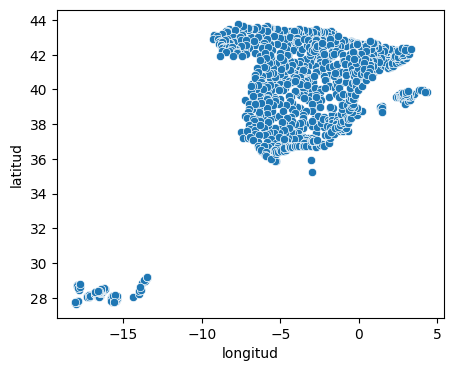

In [28]:
plt.figure(figsize=(5, 4))
sns.scatterplot(df_aws, x = 'longitud', y = 'latitud')

In [29]:
# Save dataset processed
df_aws.to_csv('./data/processed/AWS_info.csv', index = False)

Now lets investigate `Basque Country Weather data.`

In [31]:
df_weather_euskadi = pd.read_csv('./data/raw/BC_weather_month_year_RAW.csv')

with pd.option_context('display.max_columns', None):
    display(df_weather_euskadi.head())

,fecha,indicativo,p_max,hr,nw_55,tm_min,ta_max,ts_min,nt_30,w_racha,np_100,nw_91,np_001,ta_min,w_rec,e,np_300,p_mes,w_med,nt_00,ti_max,tm_mes,tm_max,np_010,n_cub,n_des,n_nub,evap,n_fog,n_tor,n_gra,n_llu,n_nie,nv_0050,nv_1000,nv_0100,q_max,q_mar,q_med,q_min,inso,p_sol,ts_20,ts_10,ts_50,glo
0,2009-10,1012P,35.2(22),74.0,1.0,12.7,30.8(06),22.9,1.0,16/15.3(20),3.0,0.0,12.0,1.9(16),99.0,142.0,1.0,117.4,4.0,0.0,11.4,16.8,20.9,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-11,1012P,NaN,67.0,14.0,10.6,26.9(01),17.2,0.0,25/27.2(07),NaN,1.0,NaN,5.3(30),254.0,107.0,NaN,NaN,10.0,0.0,10.3,14.1,17.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-12,1012P,NaN,73.0,10.0,6.6,19.6(29),16.0,0.0,14/26.1(21),NaN,1.0,NaN,-1.3(19),189.0,88.0,NaN,NaN,7.0,3.0,2.4,9.4,12.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-13,1012P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-1,1012P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Oldest data
df_weather_euskadi.fecha.min()

'1928-1'

AEMET mean data per year is directly provideed by AEMET and storage in the month numer "13". BUT after some inspections I realize this data is full of missing values, so I won't use that information. Instead, if needed during the EDA I will construct my own mean-weather data per year.

In [34]:
# Filter: only months from 1 to 12
df_weather_month_year_euskadi = df_weather_euskadi[~df_weather_euskadi['fecha'].str.contains(r'-13$', regex=True)]

df_weather_month_year_euskadi = df_weather_month_year_euskadi.rename(columns={'indicativo' : 'idema'})
df_weather_month_year_euskadi.sort_values(by = ['idema', 'fecha'])

df_weather_month_year_euskadi.head()

,fecha,idema,p_max,hr,nw_55,tm_min,ta_max,ts_min,nt_30,w_racha,...,q_max,q_mar,q_med,q_min,inso,p_sol,ts_20,ts_10,ts_50,glo
0,2009-10,1012P,35.2(22),74.0,1.0,12.7,30.8(06),22.9,1.0,16/15.3(20),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-11,1012P,NaN,67.0,14.0,10.6,26.9(01),17.2,0.0,25/27.2(07),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-12,1012P,NaN,73.0,10.0,6.6,19.6(29),16.0,0.0,14/26.1(21),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-1,1012P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-2,1012P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df_weather_month_year_euskadi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11448 entries, 0 to 12401
Data columns (total 46 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fecha    11448 non-null  object 
 1   idema    11448 non-null  object 
 2   p_max    10419 non-null  object 
 3   hr       9111 non-null   float64
 4   nw_55    7747 non-null   float64
 5   tm_min   10148 non-null  float64
 6   ta_max   10143 non-null  object 
 7   ts_min   10115 non-null  float64
 8   nt_30    10143 non-null  float64
 9   w_racha  7772 non-null   object 
 10  np_100   10410 non-null  float64
 11  nw_91    7747 non-null   float64
 12  np_001   10410 non-null  float64
 13  ta_min   10148 non-null  object 
 14  w_rec    7463 non-null   float64
 15  e        9176 non-null   float64
 16  np_300   10410 non-null  float64
 17  p_mes    10423 non-null  float64
 18  w_med    8550 non-null   float64
 19  nt_00    10148 non-null  float64
 20  ti_max   10110 non-null  float64
 21  tm_mes   10137 no

The last step is combine AWS info with the annual monthly weather data of the Basque Country, so I will have in a single dataset all the weather and AWS information.

In [39]:
# Merge weather data with AWS information
df_basque_country = df_weather_month_year_euskadi.merge(df_aws, how = 'left', on = 'idema')

with pd.option_context('display.max_columns', None):
    display(df_basque_country.head(8))

,fecha,idema,p_max,hr,nw_55,tm_min,ta_max,ts_min,nt_30,w_racha,np_100,nw_91,np_001,ta_min,w_rec,e,np_300,p_mes,w_med,nt_00,ti_max,tm_mes,tm_max,np_010,n_cub,n_des,n_nub,evap,n_fog,n_tor,n_gra,n_llu,n_nie,nv_0050,nv_1000,nv_0100,q_max,q_mar,q_med,q_min,inso,p_sol,ts_20,ts_10,ts_50,glo,latitud,provincia,altitud,nombre,indsinop,longitud
0,2009-10,1012P,35.2(22),74.0,1.0,12.7,30.8(06),22.9,1.0,16/15.3(20),3.0,0.0,12.0,1.9(16),99.0,142.0,1.0,117.4,4.0,0.0,11.4,16.8,20.9,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.326389,GIPUZKOA,120,IRUN,NaN,-1.796667
1,2009-11,1012P,NaN,67.0,14.0,10.6,26.9(01),17.2,0.0,25/27.2(07),NaN,1.0,NaN,5.3(30),254.0,107.0,NaN,NaN,10.0,0.0,10.3,14.1,17.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.326389,GIPUZKOA,120,IRUN,NaN,-1.796667
2,2009-12,1012P,NaN,73.0,10.0,6.6,19.6(29),16.0,0.0,14/26.1(21),NaN,1.0,NaN,-1.3(19),189.0,88.0,NaN,NaN,7.0,3.0,2.4,9.4,12.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.326389,GIPUZKOA,120,IRUN,NaN,-1.796667
3,2009-1,1012P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.326389,GIPUZKOA,120,IRUN,NaN,-1.796667
4,2009-2,1012P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.326389,GIPUZKOA,120,IRUN,NaN,-1.796667
5,2009-3,1012P,30.4(04),68.0,3.0,7.1,24.5(17),13.5,0.0,29/27.8(05),4.0,1.0,13.0,3.2(04),169.0,88.0,1.0,97.8,7.0,0.0,8.6,10.9,14.6,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.326389,GIPUZKOA,120,IRUN,NaN,-1.796667
6,2009-4,1012P,74.4(10),75.0,2.0,8.4,24.6(09),11.0,0.0,12/20.0(09),10.0,0.0,18.0,6.2(18),179.0,105.0,1.0,251.6,7.0,0.0,10.5,12.2,15.9,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.326389,GIPUZKOA,120,IRUN,NaN,-1.796667
7,2009-5,1012P,24.6(14),78.0,1.0,12.0,26.2(30),15.5,0.0,23/16.4(15),4.0,0.0,17.0,8.9(06),143.0,143.0,0.0,135.8,7.0,0.0,13.5,15.6,19.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.326389,GIPUZKOA,120,IRUN,NaN,-1.796667


In [40]:
df_basque_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11448 entries, 0 to 11447
Data columns (total 52 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fecha      11448 non-null  object 
 1   idema      11448 non-null  object 
 2   p_max      10419 non-null  object 
 3   hr         9111 non-null   float64
 4   nw_55      7747 non-null   float64
 5   tm_min     10148 non-null  float64
 6   ta_max     10143 non-null  object 
 7   ts_min     10115 non-null  float64
 8   nt_30      10143 non-null  float64
 9   w_racha    7772 non-null   object 
 10  np_100     10410 non-null  float64
 11  nw_91      7747 non-null   float64
 12  np_001     10410 non-null  float64
 13  ta_min     10148 non-null  object 
 14  w_rec      7463 non-null   float64
 15  e          9176 non-null   float64
 16  np_300     10410 non-null  float64
 17  p_mes      10423 non-null  float64
 18  w_med      8550 non-null   float64
 19  nt_00      10148 non-null  float64
 20  ti_max

The code below is just a demostration of how now I can scatter-plot the results. I'll us it in a function during the EDA.

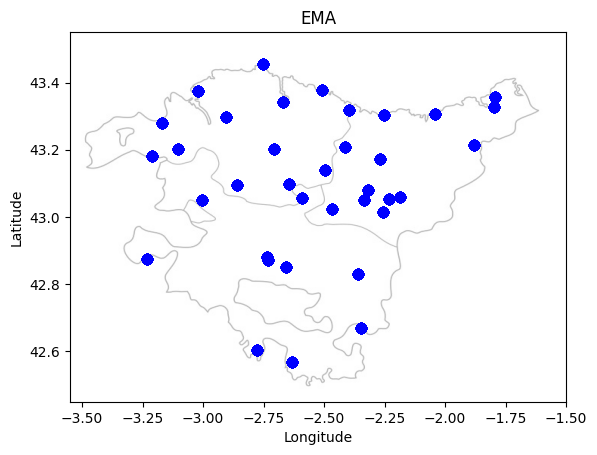

In [46]:
# Example of how could I plot some results

# Load the image
image_path = './img/basque_country_map.jpg'
image = mpimg.imread(image_path)

# Data for the scatter plot
x = df_basque_country.longitud
y = df_basque_country.latitud

# Configure the plot
fig, ax = plt.subplots()

# Add the background image, adjusting the values according to the data
extent = [-3.55, -1.55, 42.47, 43.47]
ax.imshow(image, extent=extent, aspect='auto', alpha=0.3)

# Create the scatter plot
ax.scatter(x, y, c='blue', s=50)  # Customize color and size of points

# Adjust the axis limits
ax.set_xlim([-3.55, -1.5])
ax.set_ylim([42.45, 43.55])

# (Optional) Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('EMA')

# Show the plot
plt.show()


Finally, I save the dataset.

In [47]:
df_basque_country.to_csv('./data/processed/BC_weather_month_year.csv', 
                         index=False)